# Single Subject Segmentation Q1K - Resting state

In [1]:
#use these commented parameters for testing this notebook outside of the automated loop of q1k_automated_reports.ipynb
subject_id = "15251026P"

task_id = "RS"
session_id = "01"
run_id = "1"

##use these parameters when executing this notebook from the automation notebook..
#subject_id = ""
#task_id = ""
#session_id = ""
#run_id = ""


In [2]:
# import packages
#import q1k_sync_tools as qst
import mne
import mne_bids
#mne.viz.set_browser_backend('qt')
#%matplotlib qt
#pd.options.mode.chained_assignment = None
#import pylossless as ll
import numpy as np
import pandas as pd
#import glob
from collections import OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import shutil
import pylossless as ll

import warnings
warnings.filterwarnings('ignore')


In [3]:
common_freqs = {
    'delta' : (0,4),
    'theta': (4, 7),
    'alpha': (8, 12),
    'beta':(13, 30),
    'gamma': (30, 45)
}

frontal_roi = ['E18','E19','E23','E24','E27','E3','E4','E10','E118','E123','E124']

# Set the parameters and read the pylossless data.

In [4]:
project_path = "/project/def-emayada/q1k/experimental/HSJ/"
pylossless_path = "derivatives/pylossless/"
#pylossless_path = "derivatives/pylossless/"
#postproc_path = ""
postproc_path = "derivatives/postproc/"
#task_id_in = "VEP"
#task_id_out = "VEP"
#subject_id = '096'
#session_id = '01'

bids_path = mne_bids.BIDSPath(
    subject=subject_id, session=session_id, task=task_id, run="1", datatype="eeg", suffix="eeg",root=project_path + pylossless_path
)
print(bids_path)

/project/def-emayada/q1k/experimental/HSJ/derivatives/pylossless/sub-15251026P/ses-01/eeg/sub-15251026P_ses-01_task-RS_run-1_eeg.edf


In [5]:
# Read the BIDS pylossless output file..
eeg_raw = mne_bids.read_raw_bids(bids_path=bids_path, verbose=False)

In [6]:
eeg_raw.info

<Info | 13 non-empty values
 bads: 4 items (E125, E126, E127, E128)
 ch_names: E1, E2, E3, E4, E5, E6, E7, E8, E9, E10, E11, E12, E13, E14, ...
 chs: 129 EEG, 7 Stimulus
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition
 dig: 132 items (3 Cardinal, 129 EEG)
 experimenter: mne_anonymize
 highpass: 1.0 Hz
 line_freq: 60.0
 lowpass: 100.0 Hz
 meas_date: 2024-06-13 18:27:18 UTC
 nchan: 136
 projs: []
 sfreq: 1000.0 Hz
 subject_info: 3 items (dict)
>

In [75]:
eeg_events, eeg_event_dict  = mne.events_from_annotations(eeg_raw)
eeg_event_dict

Used Annotations descriptions: ['TSYN', 'dbrk', 'dstr', 'vs01', 'vs03', 'vs04', 'vs05']


{'TSYN': 1, 'dbrk': 2, 'dstr': 3, 'vs01': 4, 'vs03': 5, 'vs04': 6, 'vs05': 7}

In [76]:
eeg_raw.annotations.description

array(['BAD_LL_noisy_ICs', 'BAD_LL_noisy', 'BAD_LL_noisy_ICs',
       'BAD_LL_noisy', 'BAD_LL_noisy_ICs', 'dstr', 'BAD_LL_noisy_ICs',
       'BAD_LL_noisy', 'vs04', 'TSYN', 'BAD_LL_noisy_ICs', 'BAD_LL_noisy',
       'BAD_LL_noisy_ICs', 'BAD_LL_noisy_ICs', 'BAD_LL_noisy',
       'BAD_LL_noisy_ICs', 'dbrk', 'BAD_LL_noisy_ICs', 'vs05', 'TSYN',
       'BAD_LL_noisy_ICs', 'BAD_LL_noisy_ICs', 'BAD_LL_noisy', 'dbrk',
       'BAD_LL_noisy_ICs', 'vs03', 'TSYN', 'BAD_LL_noisy_ICs',
       'BAD_LL_noisy_ICs', 'BAD_LL_noisy_ICs', 'BAD_LL_noisy', 'dbrk',
       'TSYN', 'vs01', 'BAD_LL_noisy_ICs', 'BAD_LL_noisy_ICs',
       'BAD_LL_noisy', 'TSYN', 'BAD_ACQ_SKIP', 'BAD_ACQ_SKIP'],
      dtype='<U16')

## Plot events

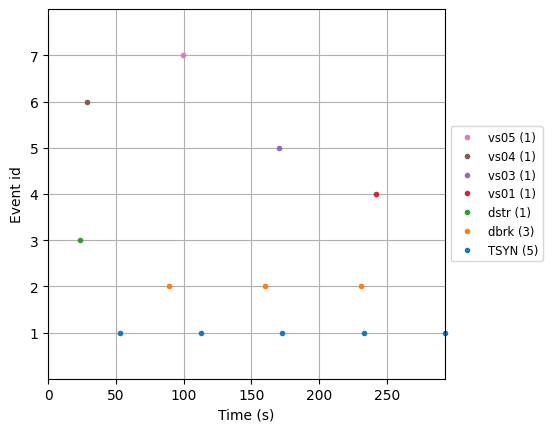

In [77]:
fig=mne.viz.plot_events(
    eeg_events, sfreq=eeg_raw.info["sfreq"], first_samp=eeg_raw.first_samp, 
    event_id=eeg_event_dict
)

### Define all rest events

In [78]:
annot_sample = []
annot_id = []
freq = eeg_raw.info["sfreq"]

# Select all annotations 
annots = [a for a in eeg_raw.annotations if a["description"] in ["dbrk", "vs01", "vs02","vs03","vs04", "vs05","vs06"]]

# Add an end annotation - there are 60 seconds after the last annotation
annots.append(OrderedDict((("onset", annots[-1]["onset"] + 60.), ("duration", 0),
                               ("description", "end"), ('orig_time', None))))

# Create new annotations for epochs
for annot, next_annot in zip(annots[:-1], annots[1:]):
    if annot["description"] == "dbrk" or annot["description"]=="end":
        continue

    annot_sample.append(np.arange(int(annot["onset"] * freq),
                                    int(next_annot["onset"] * freq),
                                    int(1 * freq)))
    id_ = eeg_event_dict[annot["description"]]
    annot_id.extend(id_ * np.ones(len(annot_sample[-1])))

annot_sample = np.concatenate(annot_sample)

rs_eeg_events=np.array([annot_sample, [0] * len(annot_sample), annot_id], dtype=int).T
rs_eeg_events = mne.merge_events(rs_eeg_events, np.unique(rs_eeg_events[:, -1]), 1)


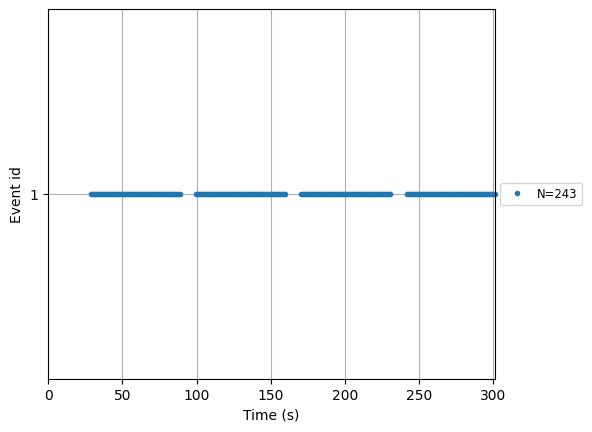

In [79]:
# Check events after creation of event structure
fig=mne.viz.plot_events(
    rs_eeg_events, sfreq=eeg_raw.info["sfreq"], first_samp=eeg_raw.first_samp,
)

In [80]:
channel_types = eeg_raw.get_channel_types()
print("Channel Types:", channel_types)
print("Channel Names:", eeg_raw.info['ch_names'])

Channel Types: ['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'stim', 'stim', 'stim', 'stim', 'stim', 'stim', 'stim']
Channel Names: ['E1', 'E2

# Interpret the annotations and apply the data selections.

Extracting EDF parameters from /project/def-emayada/q1k/experimental/HSJ/derivatives/pylossless/sub-15251026P/ses-01/eeg/sub-15251026P_ses-01_task-RS_run-1_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /project/def-emayada/q1k/experimental/HSJ/derivatives/pylossless/sub-15251026P/ses-01/eeg/sub-15251026P_ses-01_task-RS_run-1_events.tsv.
Reading channel info from /project/def-emayada/q1k/experimental/HSJ/derivatives/pylossless/sub-15251026P/ses-01/eeg/sub-15251026P_ses-01_task-RS_run-1_channels.tsv.
The stimulus channel "STI 014" is present in the raw data, but not included in channels.tsv. Removing the channel.
Reading electrode coords from /project/def-emayada/q1k/experimental/HSJ/derivatives/pylossless/sub-15251026P/ses-01/eeg/sub-15251026P_ses-01_space-CapTrak_electrodes.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading /project/def-emayada/q1k/experimental/HSJ/derivatives/pylossless/sub-1

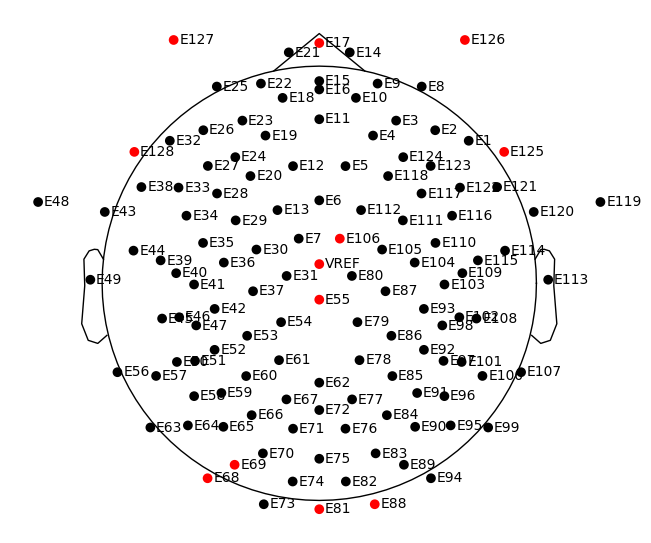

Reading 0 ... 312999  =      0.000 ...   312.999 secs...
Applying ICA to Raw instance
    Transforming to ICA space (116 components)
    Zeroing out 25 ICA components
    Projecting back using 117 PCA components
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 99.1 mm
Computing interpolation matrix from 117 sensor positions
Interpolating 12 sensors
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<RawEDF | sub-15251026P_ses-01_task-RS_run-1_eeg.edf, 136 x 313000 (313.0 s), ~324.9 MB, data loaded>

In [81]:
ll_state = ll.LosslessPipeline()
ll_state = ll_state.load_ll_derivative(bids_path)
bids_path_str=str(bids_path)
# Merge marks down to bads (aka manual)
ll_qcr = ll_state.raw.copy()
manual = []
for flag_type in ll_state.flags['ch']:
    manual.extend(ll_state.flags['ch'][flag_type])
print(ll_state.flags['ch'])
ll_qcr.info['bads'].extend(manual)
ll_qcr.info['bads'] = list(set(ll_qcr.info['bads']))

fig = ll_qcr.plot_sensors(show_names=True)

# Read the ICLabel info from file and add to exclude
df = pd.read_csv(bids_path_str.replace('_eeg.edf', '_iclabels.tsv'), sep='\t')
ll_state.ica2.exclude = list(df[df['ic_type'].str.match('eog|muscle|ch_noise|ecg')].index)

# Load the data and apply the ICA
ll_qcr.load_data()
ll_state.ica2.apply(ll_qcr)
ll_qcr = ll_qcr.filter(l_freq=1.0, h_freq=50.0)
ll_qcr = ll_qcr.interpolate_bads()
ll_qcr = ll_qcr.set_eeg_reference(ref_channels="average")
ll_qcr

In [82]:
#show channel types...
channel_types = eeg_raw.get_channel_types()
print("Channel Types:", channel_types)
print("Channel Names:", eeg_raw.info['ch_names'])

Channel Types: ['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'stim', 'stim', 'stim', 'stim', 'stim', 'stim', 'stim']
Channel Names: ['E1', 'E2

In [83]:
rs_event_id= {"rest":1}

# Segment the data to create epochs

In [84]:
# Epoch structure is created for ALL events, then you 'segment' by indexing into it
epochs = mne.Epochs(ll_qcr, rs_eeg_events, tmin=-0.2, tmax=0.8, on_missing='warn', event_id=rs_event_id)
epochs.save(project_path + pylossless_path + postproc_path + 'epoch_fif_files/RS/' + bids_path.basename + '_epo.fif', overwrite=True)

Not setting metadata
243 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 243 events and 1001 original time points ...
42 bad epochs dropped
Using data from preloaded Raw for 1 events and 1001 original time points ...
Using data from preloaded Raw for 201 events and 1001 original time points ...


In [85]:
epochs

<Epochs | 201 events (all good), -0.2 – 0.8 s (baseline -0.2 – 0 s), ~154 kB, data not loaded,
 'rest': 201>

In [86]:
epochs = epochs[['rest']]
display(epochs)
#epochs.save(project_path + pylossless_path + postproc_path + 'epoch_fif_files/PLR/' + bids_path.basename + '_epo.fif', overwrite=True)

<Epochs | 201 events (all good), -0.2 – 0.8 s (baseline -0.2 – 0 s), ~154 kB, data not loaded,
 'rest': 201>

In [87]:
epo_power= epochs.compute_psd(fmin=0,fmax=50)
psds, freqs = epo_power.get_data(return_freqs=True)
print(f"\nPSDs shape: {psds.shape}, freqs shape: {freqs.shape}")

Using data from preloaded Raw for 201 events and 1001 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows

PSDs shape: (201, 129, 51), freqs shape: (51,)


## Plot power spectrum

Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


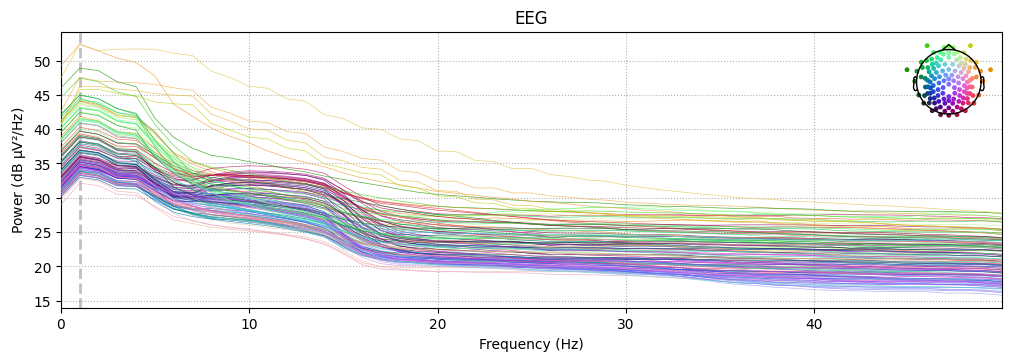

In [88]:
fig=epo_power.plot(picks="eeg", exclude="bads", amplitude=False)

Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


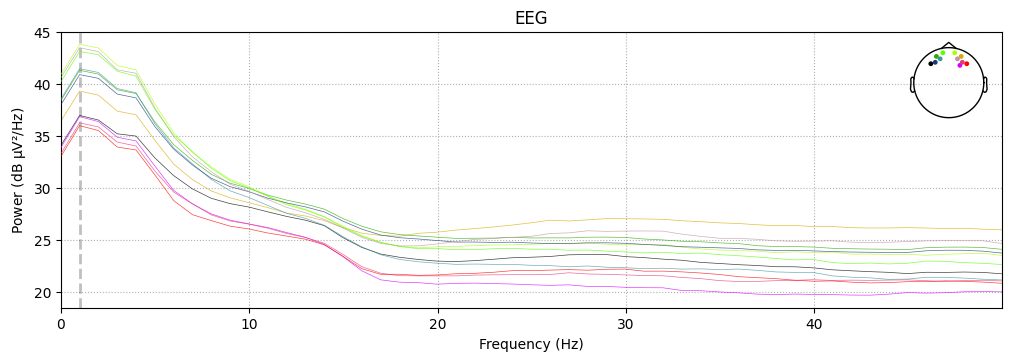

In [89]:
fig=epo_power.plot(picks=frontal_roi, exclude="bads", amplitude=False)

Averaging across epochs before plotting...


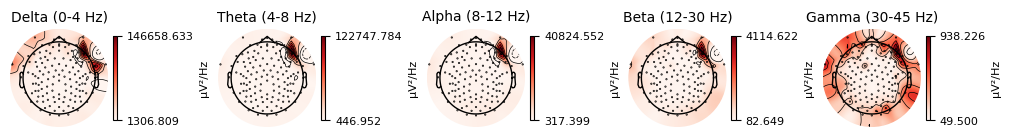

In [90]:
fig=epo_power.plot_topomap(ch_type="eeg", agg_fun=np.median)

In [69]:
!jupyter nbconvert --output {"session_reports/RS/" + bids_path.basename + ".html"} --TagRemovePreprocessor.remove_all_outputs_tags='{"exclude"}' --no-input --to html session_seg_RS.ipynb

^C
Traceback (most recent call last):
  File "/home/gabe030/.local/bin/jupyter-nbconvert", line 5, in <module>
    from nbconvert.nbconvertapp import main
  File "/home/gabe030/.local/lib/python3.12/site-packages/nbconvert/__init__.py", line 6, in <module>
    from . import filters, postprocessors, preprocessors, writers
  File "/home/gabe030/.local/lib/python3.12/site-packages/nbconvert/filters/__init__.py", line 8, in <module>
